In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from torch_unet.tools.dataset import TrainingSet, TestSet
from torch_unet.unet import UNet
import numpy as np

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, random_split
import torch
import logging
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm
from torch_unet.tools.evaluation import eval_net
from torchsummary import summary
from torch_unet.tools.losses import DiceCoeff

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [2]:
DATADIR = "../Datasets/training/"
IMAGE_DIR = DATADIR + "images/"
MASK_DIR = DATADIR + "groundtruth/"
MASK_THRESHOLD = 0.25


In [27]:
dataset = TrainingSet(IMAGE_DIR, MASK_DIR, MASK_THRESHOLD, patch_size=80, step=20, rotation_angles=None, augmentation=False)

INFO: Created dataset from 100 original images, scale factor 289.0, patch size 80, step 20, rotations None, total images 28900.0


(80, 80, 3) (80, 80)
(80, 80, 3) (80, 80)


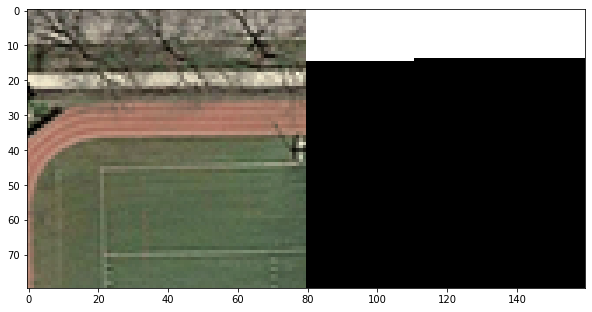

In [33]:
i = 289*2
img = dataset[i]['image'].detach().numpy().transpose((1,2,0))
mask = dataset[i]['mask'].detach().numpy()[0]
show_side_by_side(img, mask)

In [5]:
net = UNet(n_channels=3, n_classes=1, depth=4, init_filters=64, padding=True)

In [26]:
from albumentations import HorizontalFlip, VerticalFlip, RandomRotate90, Transpose

In [17]:
img = dataset.get_raw_image(0)
mask = dataset.get_raw_mask(0)

In [18]:
from torch_unet.utils import show_side_by_side

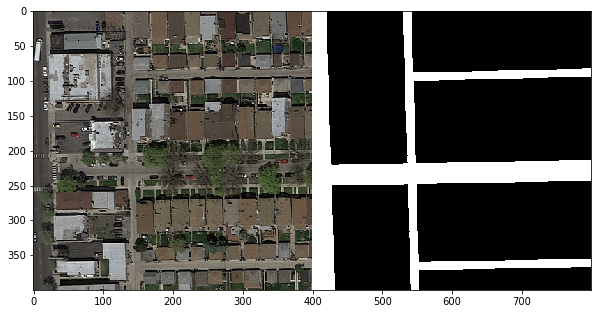

In [19]:
show_side_by_side(img, mask)

In [43]:
from torch_unet.data_augmentation import StochasticAugmentation
s = StochasticAugmentation(0.5)

In [44]:
img_a, mask_a = s.augment_image(img, mask)

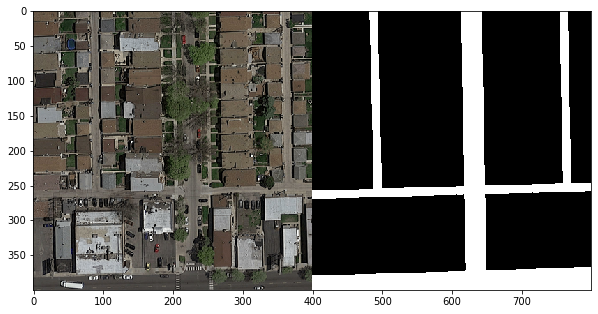

In [45]:
show_side_by_side(img_a, mask_a)

In [36]:
import pandas as pd
import matplotlib.image as mpimg

In [37]:
import re
def patch_to_label(patch):
    df = np.mean(patch)
    if df > 0.5:
        return 1
    else:
        return 0


def mask_to_submission_strings(image_filename):
    """Reads a single image and outputs the strings that should go into the submission file"""
    img_number = int(re.search(r"\d+", image_filename).group(0))
    im = mpimg.imread(image_filename)
    patch_size = 16
    #im = ((im > 0.49) * 1)
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i: i + patch_size, j: j + patch_size]
            label = patch_to_label(patch)
            yield ("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, *image_filenames):
    """Converts images into a submission file"""
    with open(submission_filename, "w") as f:
        f.write("id,prediction\n")
        for fn in image_filenames[0:]:
            f.writelines("{}\n".format(s) for s in mask_to_submission_strings(fn))

In [127]:
submission_filename = "../Datasets/submission.csv"
image_filenames = []
for i in range(1, 51):
    image_filename = "../predictions/test_" + "%.d" % i + ".png"
    image_filenames.append(image_filename)

masks_to_submission(submission_filename, *image_filenames)

In [128]:
#submission = pd.read_csv("../../../../../road_segmentation/submissions/submission_17-12-2019.csv")
#submission = pd.read_csv("../Datasets/submissions/submission_best.csv")
submission = pd.read_csv("../Datasets/submission.csv")
solution = pd.read_csv("../Datasets/solution.csv").rename(columns={'prediction': 'actual'}).drop(columns=['Usage'])
merged = submission.merge(solution, on='id')

In [129]:
solution.shape[0], merged.shape[0]

(72200, 72200)

In [130]:
tp = merged[(merged['actual'] == 1) & (merged['prediction'] == 1)]['id'].count()
fn = merged[(merged['actual'] == 1) & (merged['prediction'] == 0)]['id'].count()
fp = merged[(merged['actual'] == 0) & (merged['prediction'] == 1)]['id'].count()

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

In [131]:
f1_score, precision, recall

(0.8746012654918162, 0.8895803414711984, 0.8601182823347905)

In [181]:
f1_score, precision, recall

(0.8672949842920593, 0.9160707134275416, 0.8234507585497557)

In [88]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np

In [102]:
sigmoid = nn.Sigmoid()

t = np.round(np.random.rand(64))[:, None]
o = np.random.rand(64,1) - 0.5

t = Variable(torch.Tensor(t))
o = Variable(torch.Tensor(o))



In [104]:
print(nn.BCEWithLogitsLoss()(sigmoid(o), t))
print(nn.BCELoss()(sigmoid(o), t)) # Different numbers

tensor(0.7197)
tensor(0.6861)


In [99]:
t.shape

torch.Size([64, 1])

In [92]:
o.shape

torch.Size([64, 1])